# MDLZ price prediction using the Prophet Library

For Python working environment 3.10 or lower

1. Load and Summarize Dataset

In [20]:
#!pip install prophet

In [21]:
import prophet
print('Prophet %s' % prophet.__version__)

Prophet 1.1.5


In [22]:
import yfinance as yf
import pandas as pd

# Load the data
stock_name = yf.download('MDLZ', start='2010-01-01', end='2024-12-31')

# Summarize the dataset
stock_name.shape

[*********************100%%**********************]  1 of 1 completed


(3634, 6)

In [23]:
stock_name.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,27.299999,27.480000,27.170000,27.430000,13.157023,7953300
2010-01-05,28.320000,28.809999,28.010000,28.770000,13.799762,37152800
2010-01-06,28.299999,29.160000,28.100000,28.969999,13.895689,40848800
2010-01-07,29.049999,29.090000,28.570000,28.900000,13.862114,18359900
2010-01-08,28.760000,28.940001,28.530001,28.930000,13.876503,11000000


In [24]:
stock_name.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3634.000000,3634.000000,3634.000000,3634.000000,3634.000000,3.634000e+03
mean,46.206285,46.571024,45.831123,46.210685,39.068510,8.633570e+06
std,13.192351,13.280875,13.083835,13.183511,16.925741,4.830991e+06
min,25.030001,25.180000,24.500000,25.110001,13.157023,1.833800e+06
25%,35.435000,35.689999,35.172499,35.422499,25.167394,5.877050e+06
50%,43.085001,43.369999,42.710001,43.029999,36.971100,7.479750e+06
75%,56.947500,57.495000,56.412498,56.932499,52.623074,9.878650e+06
max,78.400002,78.589996,77.739998,78.360001,76.551323,7.419660e+07


2. Plot the Data on Column 'Close'

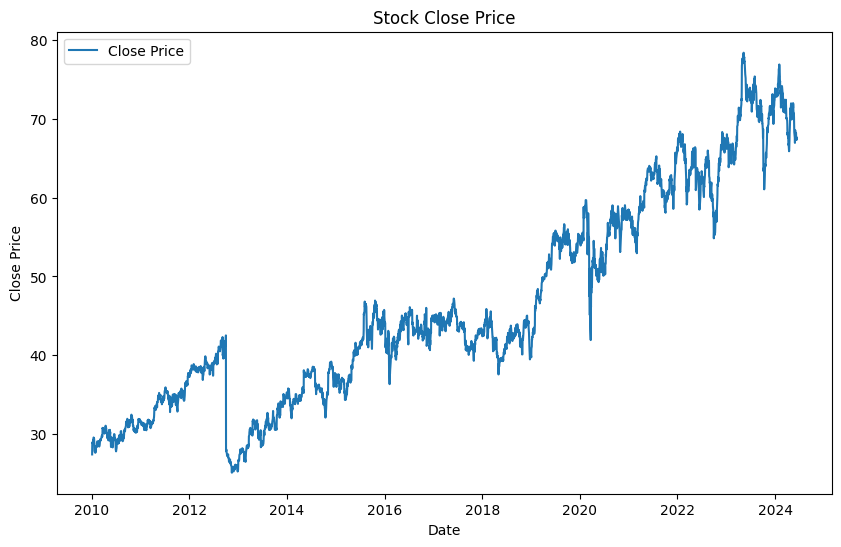

In [25]:
import matplotlib.pyplot as plt

# Plot the closing price
plt.figure(figsize=(10, 6))
plt.plot(stock_name['Close'], label='Close Price')
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

3. Data Pre-processing and Fit the Prophet Model

In [26]:
from prophet import Prophet

# Prepare the expected column names
df = stock_name[['Close']].reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

# Fit the Prophet model
model = Prophet()
model.fit(df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/ta8f8ivn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/074wq4u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46121', 'data', 'file=/tmp/tmpmgh_v8o1/ta8f8ivn.json', 'init=/tmp/tmpmgh_v8o1/074wq4u6.json', 'output', 'file=/tmp/tmpmgh_v8o1/prophet_model77141w5y/prophet_model-20240612002133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
df

,ds,y
0,2010-01-04,27.430000
1,2010-01-05,28.770000
2,2010-01-06,28.969999
3,2010-01-07,28.900000
4,2010-01-08,28.930000
...,...,...
3629,2024-06-05,67.980003
3630,2024-06-06,68.190002
3631,2024-06-07,67.809998
3632,2024-06-10,67.300003


4. Make an In-Sample (in training set sample) Forecast and Review the Results
- It can be useful to make a forecast on historical data.

In [28]:
# Make a forecast
# Prophet.make_future_dataframe: https://facebook.github.io/prophet/docs/quick_start.html
# predict method: https://facebook.github.io/prophet/docs/quick_start.html

future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

# Summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2010-01-04  28.190049   25.307573   31.060288
1 2010-01-05  28.249007   25.246381   31.469378
2 2010-01-06  28.244387   25.224283   31.322112
3 2010-01-07  28.277845   25.362117   31.422782
4 2010-01-08  28.301539   25.427102   31.311661


5. Visualize the Prediction in the Context of the Training Dataset

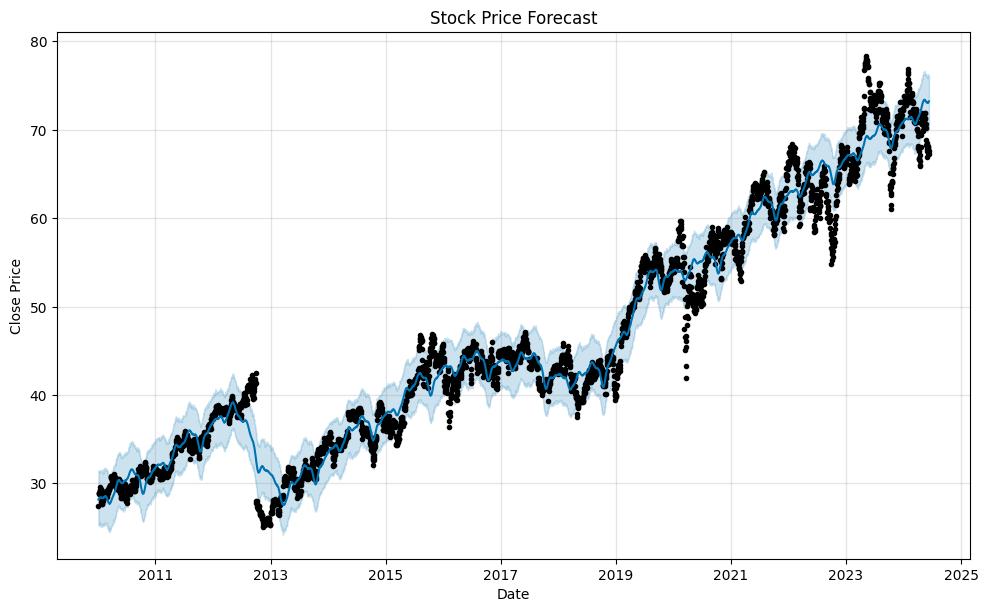

In [29]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

6. Make an Out-of-Sample Forecast (Next 365 Days)

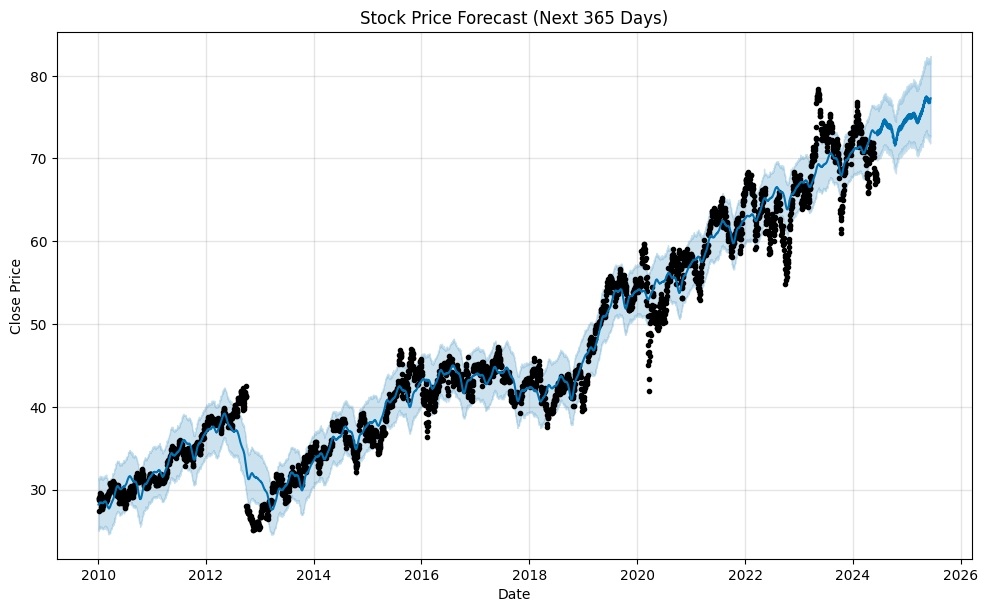

In [30]:
# Extend the forecast for the next 365 days
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the extended forecast
fig = model.plot(forecast)
plt.title('Stock Price Forecast (Next 365 Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

7. Evaluate Forecast Model

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [32]:
# Remove the last 12 months from the training data
train = df[df['ds'] < '2023-01-01']

In [33]:
test = df[df['ds'] >= '2023-01-01']

In [34]:
print(test.y.max())

78.36000061035156


In [35]:
# Fit the model on the training data
model = Prophet()
model.fit(train)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/8193601l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/2d74jp5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92394', 'data', 'file=/tmp/tmpmgh_v8o1/8193601l.json', 'init=/tmp/tmpmgh_v8o1/2d74jp5g.json', 'output', 'file=/tmp/tmpmgh_v8o1/prophet_model8bbu8tkd/prophet_model-20240612002139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
# Make a forecast for the test period
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

In [37]:
# Calculate mean absolute error
y_true = test['y'].values
y_pred = forecast['yhat'][-len(test):].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 3.7740146597497706
Mean Squared Error: 22.032384275050156
R-squared: -0.8154948378029072


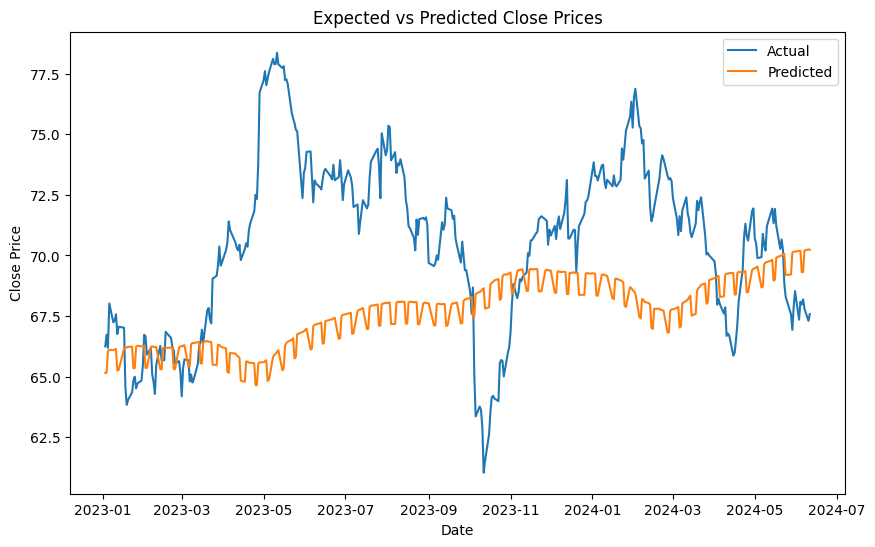

In [38]:
# Plot expected vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], y_true, label='Actual')
plt.plot(test['ds'], y_pred, label='Predicted')
plt.title('Expected vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

The Mean Absolute Error (MAE) is a metric used to evaluate the performance of a forecasting model. It measures the average absolute difference between the predicted values and the actual values. For instance, an MAE of 3.77711718360421 indicates that, on average, the model's predictions deviate from the actual values by approximately 3.78 units. A lower MAE indicates better accuracy, as it means that the model's predictions are closer to the actual values. Conversely, a higher MAE suggests that the model's predictions are less accurate.

Mean Squared Error (MSE) is another commonly used metric for evaluating the accuracy of a predictive model. It measures the average of the squares of the errors, which are the differences between the predicted values and the actual values. An MSE of 22.073904079594964 reflects that the squared differences between the predicted and actual values are, on average, about 22.07. This metric emphasizes larger errors more than MAE due to the squaring of each error term.

The R-squared (R²) value is a statistical measure that indicates how well the regression model fits the observed data. Unfortunately, an R-squared value of -0.8174275291868067 suggested that work has to done to fine-tune the model structure and data quality.

## Studying the Trend Line

Reading the trend line of the actual stock close prices in 2023, MDLZ stock peak around May 2023, dip in October 2023 and peak Peak in Feb 2024 in the actual close price trend line.

This might have been impacted by some of the major events that impacts the Mondelēz (MDLZ) stock, including, but not limited to:

In May 2023, Mondelez reported strong quarterly results, with a significant increase in net revenue and earnings per share. The company's performance was driven by strong consumer demand, successful price execution, and efficient cost management. Mondelez raised its growth outlook for the year, which positively impacted its stock price​ (Mondelēz International, Inc., foodnavigator-usa.com)​.

In October 2023, Mondelez experienced a decline in its stock price due to several factors. Rising costs for raw materials such as cocoa, hazelnut, and sugar prompted planned price hikes. Consumer also changed their spending patterns towards more value-oriented products and smaller pack sizes.

Additionally, the surge in popularity of weight loss drugs like Ozempic influenced consumer preferences, shifting them towards healthier snacking options. This trend pressured Mondelez to innovate and adapt its product offerings to align with changing consumer demands. (foodnavigator-usa.com, washingtonpost.com)​.

By February 2024, Mondelez's stock had rebounded. The company reported that the issues leading to the October dip were one-off events and projected a return to positive volume growth in North America. The company's confidence was supported by strong overall performance in 2023, which was characterized as its "best year ever," with significant growth in organic net revenue and adjusted gross profit. This strong performance likely contributed to renewed investor confidence and a subsequent peak in the stock price​ (foodnavigator-usa.com)​.





8. Attempt to improve the scores

In [39]:
# Adjust the test data date range
train = df[df['ds'] < '2023-01-01']

In [40]:
test = df[(df['ds'] >= '2023-01-01') & (df['ds'] <= '2023-03-15')]

In [41]:
# Fit the model on the training data
model = Prophet()
model.fit(train)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/5zu0adbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmgh_v8o1/d6a02csu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38003', 'data', 'file=/tmp/tmpmgh_v8o1/5zu0adbg.json', 'init=/tmp/tmpmgh_v8o1/d6a02csu.json', 'output', 'file=/tmp/tmpmgh_v8o1/prophet_modeloy41nr3v/prophet_model-20240612002143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [42]:
# Make a forecast for the test period
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

In [43]:
# Calculate mean absolute error
y_true = test['y'].values
y_pred = forecast['yhat'][-len(test):].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0292237599047929
Mean Squared Error: 1.427266652138733
R-squared: -0.47317747129453513


The score improved slightly, but further analysis of the stock price movement and additional news or reports from that period would provide a clearer understanding of the factors contributing to the stock price peak and dip, and perhaps additional regressors can be added to the model using the add_regressor method to include sentiment scores alongside with traditional financial indicators to improve the Mean Absolute Error (MAE) and Mean Squared Error (MSE) scores in future stock price prediction models(references: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors).

# About Prophet Library

Prophet, developed by Facebook, is an additive regression model designed for forecasting time series data. Prophet’s ability to handle seasonality and trends, its flexibility and customizability, robustness to missing data and outliers, user-friendly interface and interpretability, and scalability and speed make it a strong candidate for predicting the stock price of a stable company like Mondelez International (MDLZ).



### Documentation Link:
https://facebook.github.io/prophet/docs/quick_start.html

## Acknowledgement:
I've learned about the Prophet Forecasting Library with the help of my tutor, Saad Khan, at the University of Toronto School of Continuing Studies (UofT SCS) Boot Camp, and I would like to thank Sharon Colson and Brandon Wong in explaining the details.

In the future, I will try to explore NeuralProphet, a time series forecasting tool that extends Facebook's Prophet model with additional features like autoregression and more sophisticated seasonality components, and compare results.

Reference link: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/